In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, XGate, CXGate

#import time
import qiskit.quantum_info as qi
from qiskit_experiments.library.tomography.mit_qst_experiment import MitigatedStateTomography
from qiskit_experiments.library.tomography.qst_experiment import StateTomography
#from qiskit.quantum_info import state_fidelity

# Creating Circuit A

In [2]:
def A_gate(theta, qubits, circ, phi=0, l = 0, f = True):
    '''Adds the gates to the circuit circ A'''
    a = qubits[0] # first qubit
    b = qubits[1] # second qubit
    
    if f == True:
        circ.cx(b,a) # adding the first CNOT, for which qubit b is the control and qubit a is the target
    else: 
        circ.x(a)
    # now comes the R dagger gate which has two parameters: theta and phi
    # but in our case phi is always zero
    ry1 = r"Y_"+str(l)+"^-1"
    ry  = r"Y_"+str(l)
    rz = r"Z_"+str(l)
    rz1 = r"Z_"+str(l)+"^-1"
    circ.ry(-(theta+np.pi/2),b, label = ry1) # rotation around the y axis
    circ.rz(-(phi+np.pi),b) # rotation around the z axis 
    
    # now the second CNOT for which target: b, control:a
    circ.cx(a,b)
    
    # and now the R gate for which we use the same two parameters
    circ.rz((phi+np.pi),b)
    circ.ry((theta+np.pi/2),b, label = ry)
    
    # and the last CNOT
    circ.cx(b,a)

In [3]:
def circ_maker(n, qubits, measure=False, f=True, classic=False): 
    '''Creates the full circuit A'''
    
    theta1 = 3*np.pi/4
    theta2 = -2.97167
    theta3 = -2.18628 
    theta4 = np.pi
    theta5 = 5.23599
    
    a = qubits[0]
    b = qubits[1]
    c = qubits[2]
    d = qubits[3]
    
    qreg = QuantumRegister(n)
    if classic: 
        creg = ClassicalRegister(4)
        circ = QuantumCircuit(qreg, creg)
    else: 
        circ = QuantumCircuit(qreg)
    circ.x(b)
    circ.x(d)
    
    A_gate(theta=theta1, qubits=[a,b], circ=circ, l=1, f=f)
    A_gate(theta=theta2, qubits=[c,d], circ=circ, l=2, f=f)
    A_gate(theta=theta3, qubits=[b,c], circ=circ, l=3)
    A_gate(theta=theta4, qubits=[a,b], circ=circ, l=4)
    A_gate(theta=theta5, qubits=[c,d], circ=circ, l=5)
    A_gate(theta=theta3, qubits=[b,c], circ=circ, l=3)

    if measure:
        circ.measure([a,b,c,d], [0,1,2,3])
    else: 
        pass 
    if classic:
        return circ, qreg, creg
    else: 
        return circ, qreg

In [4]:
def saver(filename, backend_name, time, shots, qubits, F, rho_mes, target_state, tomo_fitter_data, F_mit, 
          rho_mit, cal_matrix):  
    '''Saves the data to a file'''
    
    with open (filename+".txt", "w") as f: 
        f.write("Backend: "+backend_name+"\n")
        f.write("date: "+ str(time)+"\n")
        f.write("Qubits in use: "+str(qubits)+"\n")
        f.write("Shots: "+str(shots)+"\n")
        f.write("\n")
        f.write("Target state: "+ str(target_state)+"\n"+"\n")
        f.write("Fidelity: "+str(F)+"\n")
        f.write("Mitigated Fidelity: "+str(F_mit)+"\n"+"\n")
        
        f.write("Measured density matrix:"+ "\n")
        for i, line in enumerate(rho_mes):
            f.write(str(line))
            f.write("\n")
        f.write("\n")
            
        f.write("Mitigated density matrix:"+"\n")
        for i, line in enumerate(rho_mit):
            f.write(str(line))
            f.write("\n")
                    
        f.write("\n")
        f.write("Measurement results for the circuits:"+ "\n")
        
        
        #print(dictionary, file = f)
        for key in tomo_fitter_data:
            f.write(str(key)+": "+"\n")
            for subkey in tomo_fitter_data[key]:
                f.write("\t"+str(subkey)+": "+str(tomo_fitter_data[key][subkey])+"\n")
                
        f.write("\n")
        
        f.write("Calibration matrix:"+"\n")
        for line in cal_matrix:
            f.write(str(line)+"\n")

In [5]:
# Example run on a statevector simulator
circ, qreg = circ_maker(n=4, qubits = [0,1,2,3])
job = execute(circ, backend=Aer.get_backend('statevector_simulator'))
target_state = job.result().get_statevector(circ)
print(target_state)

Statevector([-1.38777878e-17+2.93780988e-17j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
             -5.77350310e-01-2.90185755e-16j,
              0.00000000e+00+0.00000000e+00j,
              2.88675671e-01+1.24752636e-16j,
              2.88674690e-01+2.16227266e-16j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              2.88674517e-01+8.26955458e-17j,
              2.88668804e-01+2.60761812e-16j,
              0.00000000e+00+0.00000000e+00j,
             -5.77353657e-01-5.55801360e-16j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              1.38777878e-17-2.98888736e-18j],
            dims=(2, 2, 2, 2))


## State tomography of Circuit A on IBMQ backends

In [6]:
# choose the backend and data
backend = Aer.get_backend('qasm_simulator') 
backend_name = 'Santiago'
time = "2022.06.01."
n = 4 # number of qubits needed for the state
shots = 8192

filename = "Athens1"
physical_qubits = np.array([3, 2, 1, 0]) # the initial layout of the qubits

In [7]:
# Create Cabello Circuit A
circ, qreg = circ_maker(n=n, qubits=physical_qubits, f=False)

In [8]:
# Initialize the state tomography and the local measurement error experiments
tomo_exp = MitigatedStateTomography(circuit=circ)

In [9]:
# Run the state tomography and the local measurement error experiments
tomo_data = tomo_exp.run(backend=backend, run_options={'optimization_level':3, 'initial_layout':physical_qubits, 'shots':1000})

In [19]:
# Get analysis results (both error mitigated and unmitigated) of the state tomography and the local measurement error experiments
full_tomo_data = tomo_exp.analysis.run(tomo_data, unmitigated_fit=True)

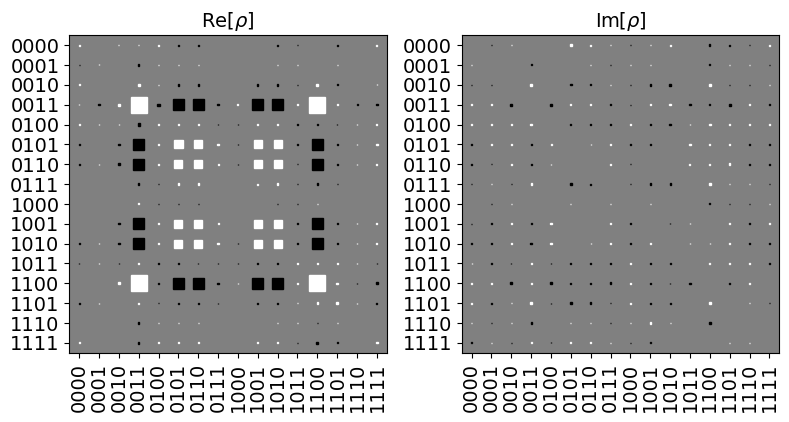

In [20]:
# Mitigated density matrix
plot_state_hinton(full_tomo_data.analysis_results('state')[0].value)

In [21]:
# Mitigated quantum state fidelity
full_tomo_data.analysis_results('state_fidelity')[0].value

0.9793316924786883

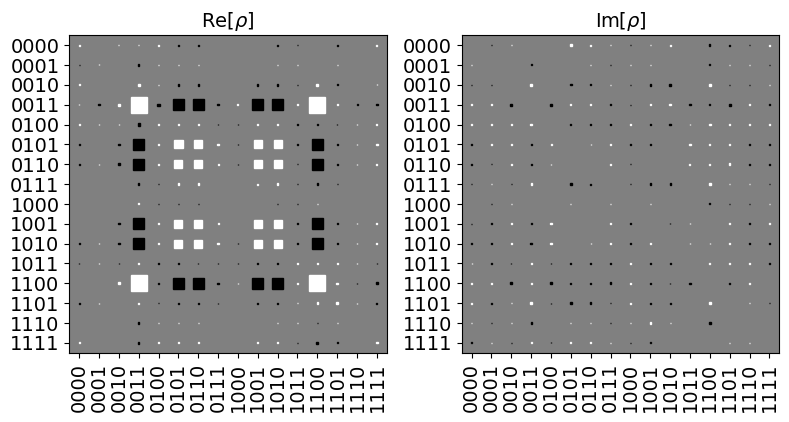

In [29]:
# Unmitigated density matrix
plot_state_hinton(full_tomo_data.analysis_results('state')[1].value)

In [30]:
# Unmitigated quantum state fidelity
full_tomo_data.analysis_results('state_fidelity')[1].value

0.9793316924786883